In [27]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.table import vstack
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# This is only style for the plot; we can ignore or change if we want
rc_fonts = {
    "text.usetex": True,
    "font.size": 30,
    'mathtext.default': 'regular',
    'axes.titlesize': 30,
    "axes.labelsize": 30,
    "legend.fontsize": 28,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    'figure.titlesize': 30,
    'figure.figsize': (13, 11),
    'text.latex.preamble': r'\usepackage{amsmath,amssymb,bm,physics,lmodern}',
    "font.family": "serif",
    "font.serif": "computer modern roman",
}

plt.rcParams.update(rc_fonts)

In [28]:
def open_csv_conc(pattern, exclude_pattern):
    csv_files = glob.glob(pattern)
    csv_files = [file for file in csv_files if exclude_pattern not in file]
    dfs = []
    for idx, file in enumerate(csv_files):
        df = pd.read_csv(file)
        # Assign labels based on file name
        if 'Halpha_emitter_wise_noise.csv' in file:
            df['label'] = -1  # Assign label -1 for noise file
        else:
            df['label'] = idx  # Assign index as label for other files
        dfs.append(df)
        
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [29]:
df_splus_wise = open_csv_conc("../Class_wise_main_unique/*.csv", "simbad")

In [30]:
for columns in df_splus_wise.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf
AllWISE
RAJ2000
DEJ2000
eeMaj
eeMin
eePA
W1mag
W2

<Axes: xlabel='PC1', ylabel='PC2'>

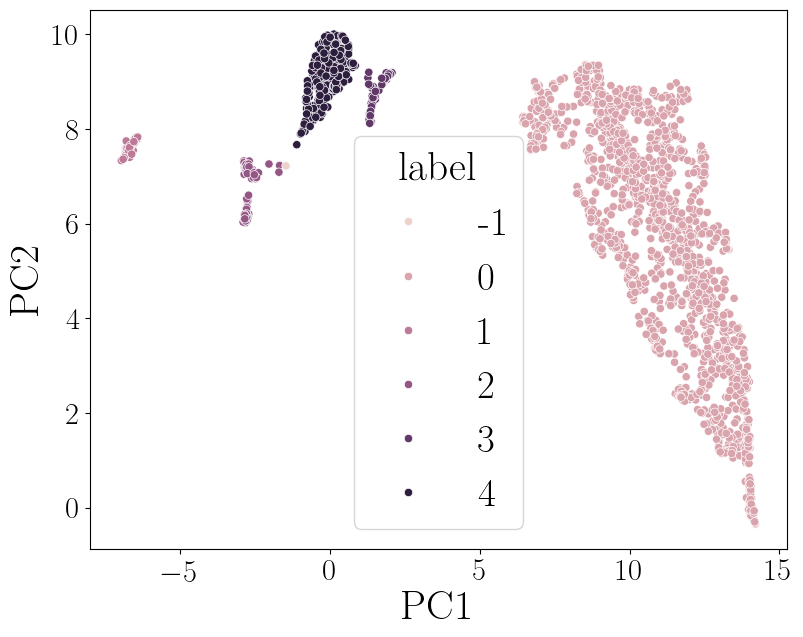

In [31]:
plt.figure(figsize=(9,7))
sns.scatterplot(x=df_splus_wise["PC1"], y=df_splus_wise["PC2"], 
                hue=df_splus_wise["label"],
                )

In [32]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [33]:
df_mag = df_splus_wise[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,14.816056,14.486720
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,12.990587,12.979302
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,14.003431,13.810323
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,14.518179,14.313604
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,15.035774,15.058778
...,...,...,...,...,...,...,...,...,...,...,...,...
1905,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,18.828121,19.304344
1906,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,18.536316,18.690256
1907,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,18.574770,18.961899
1908,19.226210,19.564507,19.093145,19.933153,19.171072,19.495451,19.859726,19.554768,19.566990,19.553707,18.895580,19.194654


In [34]:
# Creating colors
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [35]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [36]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_345045/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_345045/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_345045/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [37]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
1906,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
1907,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129
1908,19.226210,19.564507,19.093145,19.933153,19.171072,19.495451,19.859726,19.554768,19.566990,19.553707,...,-0.012222,0.001061,0.659188,0.360114,0.013283,0.671410,0.372336,0.658127,0.359053,-0.299074


In [38]:
# Drop magnitudes
df_colors = df_colors_mag.drop(columns=columns)

In [39]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,-0.385913,0.021193,-0.400243,-0.121358,-0.244292,-0.337652,-0.389431,-0.369268,-0.392612,0.355147,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
1906,-0.450952,0.119095,-0.429224,0.151297,-0.388830,-0.413261,-0.618225,-0.593130,-0.363956,0.350918,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
1907,-0.534901,-0.015257,-1.513470,-0.119953,-1.412008,-0.814728,-0.914442,-1.044880,-0.356613,0.268484,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129
1908,-0.338297,0.133065,-0.706943,0.055138,-0.269241,-0.633516,-0.328558,-0.340780,-0.327497,0.330630,...,-0.012222,0.001061,0.659188,0.360114,0.013283,0.671410,0.372336,0.658127,0.359053,-0.299074


### Making the color using some WISE filters

In [40]:
# Calculate differences between W1 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'W1-{col}'] = df_splus_wise["W1mag"] - df_splus_wise[col]

# Calculate differences between W2 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'W2-{col}'] = df_splus_wise["W2mag"] - df_splus_wise[col]


In [41]:
# Calculate difference between W1 and W2
df_colors['W1-W2'] = df_splus_wise['W1mag'] - df_splus_wise['W2mag']

In [42]:
for columns in df_colors.columns:
    print(columns)

r_PStotal - g_PStotal
r_PStotal - i_PStotal
r_PStotal - u_PStotal
r_PStotal - z_PStotal
r_PStotal - J0378_PStotal
r_PStotal - J0395_PStotal
r_PStotal - J0410_PStotal
r_PStotal - J0430_PStotal
r_PStotal - J0515_PStotal
r_PStotal - J0660_PStotal
r_PStotal - J0861_PStotal
g_PStotal - i_PStotal
g_PStotal - u_PStotal
g_PStotal - z_PStotal
g_PStotal - J0378_PStotal
g_PStotal - J0395_PStotal
g_PStotal - J0410_PStotal
g_PStotal - J0430_PStotal
g_PStotal - J0515_PStotal
g_PStotal - J0660_PStotal
g_PStotal - J0861_PStotal
i_PStotal - u_PStotal
i_PStotal - z_PStotal
i_PStotal - J0378_PStotal
i_PStotal - J0395_PStotal
i_PStotal - J0410_PStotal
i_PStotal - J0430_PStotal
i_PStotal - J0515_PStotal
i_PStotal - J0660_PStotal
i_PStotal - J0861_PStotal
u_PStotal - z_PStotal
u_PStotal - J0378_PStotal
u_PStotal - J0395_PStotal
u_PStotal - J0410_PStotal
u_PStotal - J0430_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
u_PStotal - J0861_PStotal
z_PStotal - J0378_PStotal
z_PStotal - J0395_PStotal


# Importance feature RF

### 1. Feature Importance using a Classifier

In [43]:
# Assume df_colors is your original DataFrame and cluster_labels are the labels from HDBSCAN
X = df_colors
y = df_splus_wise["Label"]

In [44]:
# Estandariza los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
# Ajustar los pesos de las clases
class_weights = {0: 1, 1: 10, 2: 10, 3: 10, 4: 5, 5:1}  # Ajusta los pesos según tus necesidades

In [46]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

RandomForestClassifier(random_state=42)

In [47]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

In [48]:
# Sort feature importances
sorted_importances = feature_importances.sort_values(ascending=False)
print(sorted_importances)

W1-W2                            0.076392
J0378_PStotal - J0515_PStotal    0.074424
u_PStotal - J0660_PStotal        0.056141
W2-z_PStotal                     0.055797
g_PStotal - u_PStotal            0.048037
                                   ...   
g_PStotal - J0660_PStotal        0.000397
J0515_PStotal - J0861_PStotal    0.000396
g_PStotal - J0861_PStotal        0.000385
z_PStotal - J0410_PStotal        0.000375
r_PStotal - J0660_PStotal        0.000322
Length: 77, dtype: float64


In [49]:
# Paso 3: Evaluar la importancia de las características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [50]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='f1_macro')
print("F1 Macro Average: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/home/luis/anaconda3/envs/my-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


F1 Macro Average: 0.96 (+/- 0.13)


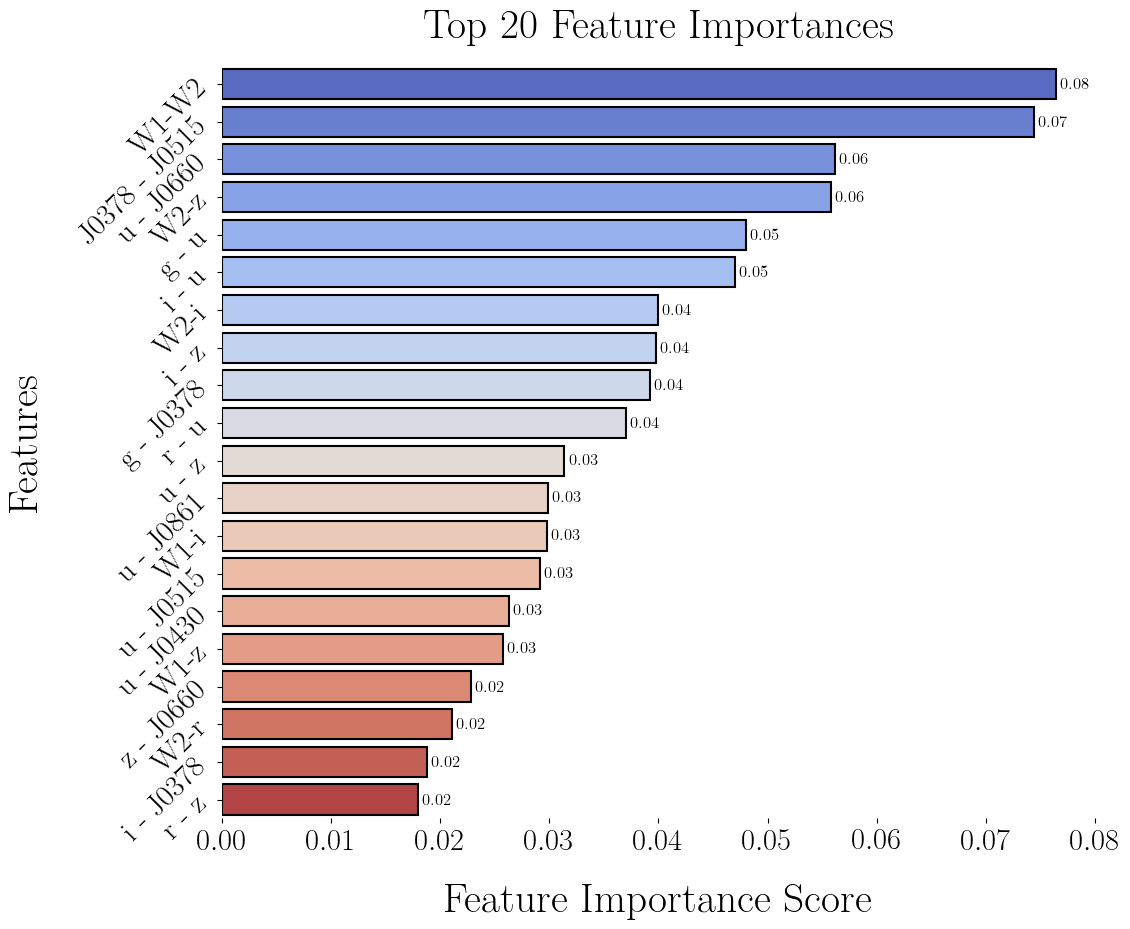

In [67]:
# Assuming sorted_importances is already defined
# Rename features for clarity
feature_names = sorted_importances.index.to_series().str.replace('_PStotal', '', regex=False)

# Create a DataFrame with renamed features and their importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': sorted_importances.values
})

# Sort by importance in descending order and reset index
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(20).reset_index(drop=True)

# Plot the feature importances
plt.figure(figsize=(12, 10))

# Use seaborn to create a bar plot with new color palette and bar format
barplot = sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',  # Assign the y variable to hue
    data=feature_importances,
    palette='coolwarm',  # Changed color palette to 'coolwarm' for better contrast
    edgecolor='black',  # Added black edge color to bars
    linewidth=1.5,  # Increased line width for the bar edges
    dodge=False,
    legend=False  # Disable the legend
)

# Customize the plot
plt.xlabel('Feature Importance Score', labelpad=20)
plt.ylabel('Features', labelpad=20)
plt.title('Top 20 Feature Importances', pad=20)

# Rotate y-axis labels
plt.yticks(rotation=45, ha='right')  # Rotate and align right

# Customize x-axis labels
plt.tick_params(axis='x')

# Add value annotations to the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', padding=3, fontsize=12)

# Improve the aesthetics
sns.despine(left=True, bottom=True)

# Adjust the layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PDF
plt.savefig("../Figs/importance-plot.pdf", format='pdf', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


### Making color color diagrams using the 20 top colors

In [44]:
# Select top 10 features (adjust the number as per your requirement)
top_features = sorted_importances.head(20).index.tolist()

# Extract top features from df_colors
df_top_features = df_colors[top_features].copy()

# Add labels from df_splus_wise to df_top_features if needed
df_top_features['Label'] = df_splus_wise['Label']
df_top_features

,W1-W2,J0378_PStotal - J0515_PStotal,u_PStotal - J0660_PStotal,W2-z_PStotal,g_PStotal - u_PStotal,i_PStotal - u_PStotal,W2-i_PStotal,i_PStotal - z_PStotal,g_PStotal - J0378_PStotal,r_PStotal - u_PStotal,...,u_PStotal - J0861_PStotal,W1-i_PStotal,u_PStotal - J0515_PStotal,u_PStotal - J0430_PStotal,W1-z_PStotal,z_PStotal - J0660_PStotal,W2-r_PStotal,i_PStotal - J0378_PStotal,r_PStotal - z_PStotal,Label
0,-0.003,2.241469,3.691219,-1.865712,-2.335818,-3.694341,-2.088934,0.223222,-1.758803,-3.286541,...,4.020555,-2.091934,2.818484,2.030217,-1.868712,-0.226344,-2.496734,-3.117326,0.631022,0
1,-0.026,0.936567,1.620079,-1.104734,-1.376997,-1.534065,-1.068601,-0.036133,-0.737583,-1.550563,...,1.631364,-1.094601,1.575981,1.360010,-1.130734,0.122147,-1.052103,-0.894651,-0.052631,0
2,-0.001,1.443823,2.383818,-1.504016,-1.578325,-2.386835,-1.600414,0.096398,-1.288057,-2.189186,...,2.576926,-1.601414,1.734091,1.113122,-1.505016,-0.099415,-1.798063,-2.096567,0.294047,0
3,0.012,1.670000,2.682674,-1.569745,-1.859390,-2.726369,-1.652484,0.082739,-1.533554,-2.478085,...,2.887249,-1.640484,1.995836,1.304157,-1.557745,-0.126434,-1.900768,-2.400533,0.331023,0
4,-0.068,1.399815,1.832880,-1.284277,-1.384190,-1.740314,-1.339340,0.055063,-0.999968,-1.777362,...,1.809876,-1.407340,1.784037,1.123011,-1.352277,0.037503,-1.302292,-1.356092,0.018015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,1.501,-0.148320,0.755390,-5.031626,-0.014330,-0.421436,-4.889075,-0.142551,0.141621,-0.400243,...,0.279167,-3.388075,0.007631,0.030975,-3.530626,0.476505,-4.910268,-0.265485,-0.121358,4
1906,1.248,0.024874,0.780142,-4.153937,0.021728,-0.548319,-4.186139,0.032202,0.062122,-0.429224,...,0.626202,-2.938139,0.065268,-0.163906,-2.905937,0.199621,-4.305234,-0.507925,0.151297,4
1907,1.549,1.055395,1.781954,-5.053207,-0.978569,-1.498213,-4.948511,-0.104696,-0.877107,-1.513470,...,1.394825,-3.399511,1.156857,0.468590,-3.504207,0.388437,-4.933254,-1.396751,-0.119953,4
1908,1.477,-0.058256,1.037573,-5.349072,-0.368646,-0.840008,-5.271145,-0.077927,0.069056,-0.706943,...,0.738499,-3.794145,0.379446,0.366163,-3.872072,0.275492,-5.404210,-0.402306,0.055138,4


In [45]:
for columns in df_top_features.columns:
    print(columns)

W1-W2
J0378_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
W2-z_PStotal
g_PStotal - u_PStotal
i_PStotal - u_PStotal
W2-i_PStotal
i_PStotal - z_PStotal
g_PStotal - J0378_PStotal
r_PStotal - u_PStotal
u_PStotal - z_PStotal
u_PStotal - J0861_PStotal
W1-i_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0430_PStotal
W1-z_PStotal
z_PStotal - J0660_PStotal
W2-r_PStotal
i_PStotal - J0378_PStotal
r_PStotal - z_PStotal
Label


In [46]:
# Define a mapping function to rename columns
def rename_columns(col):
    parts = col.split(' - ')
    if len(parts) == 2:
        return f"{parts[0].split('_')[0]} - {parts[1].split('_')[0]}"
    else:
        return col.split('_')[0]

# Apply the renaming function to all columns
df_top_features.columns = df_top_features.columns.map(rename_columns)


In [47]:
for columns in df_top_features.columns:
    print(columns)

W1-W2
J0378 - J0515
u - J0660
W2-z
g - u
i - u
W2-i
i - z
g - J0378
r - u
u - z
u - J0861
W1-i
u - J0515
u - J0430
W1-z
z - J0660
W2-r
i - J0378
r - z
Label


In [ ]:
# Create pair plot using Seaborn
sns.set(style="ticks")
g = sns.pairplot(df_top_features.dropna(), hue='Label', palette='magma',  plot_kws={'s': 70})

# Customize axis labels
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel().split('_')[0], fontsize=25)  # Remove '_PStotal' suffix from x-axis label
    ax.set_ylabel(ax.get_ylabel().split('_')[0], fontsize=25)  # Remove '_PStotal' suffix from y-axis label
    ax.tick_params(axis='both', labelsize=20)  # Set tick label size

# Customize each subplot's axis limits
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if i != j and i != 0 and j != 0:
            ax.set(xlim=[df_top_features.iloc[:, j].min() - 0.1, df_top_features.iloc[:, j].max() + 0.1],
                   ylim=[df_top_features.iloc[:, i].min() - 0.1, df_top_features.iloc[:, i].max() + 0.1])

# Adjust layout and title
#plt.suptitle('Pair Plot of Top Features', y=1.02, fontsize=16)
plt.tight_layout()

# Save the plot as a high-resolution PDF
plt.savefig("../Figs/color_color_diagrams-pairplot.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



### 2. Permutation Feature Importance

In [ ]:
# Compute permutation feature importance
perm_importance = permutation_importance(rf, X, y, n_repeats=30, random_state=42)

In [ ]:
# Create a sorted feature importance DataFrame
perm_sorted_idx = perm_importance.importances_mean.argsort()
perm_importances = pd.DataFrame(perm_importance.importances[perm_sorted_idx].T, columns=X.columns[perm_sorted_idx])

print(perm_importances)

# Constructing color color diagrams

In [ ]:
df_colors["Label"] = df_splus_wise["label"]

In [ ]:
# Get the list of columns to be used in combinations
color_columns = [col for col in df_colors.columns if col not in ['Label', 'ID']]

# Generate all unique pairs of color combinations
color_combinations = list(combinations(color_columns, 2))

In [ ]:
# Define a function to clean column names for axis labels
def clean_label(label):
    return label.replace("_PStotal", "").replace("J", "J").replace("W1mag", "W1")

# Drop rows with missing values if necessary
df_plot = df_colors.dropna()


In [ ]:
# Create a PDF to save the plots
pdf_pages = PdfPages('../Figs/all_color_color_diagrams.pdf')

# Create the plots
for x_col, y_col in color_combinations:
    plt.figure(figsize=(6, 6))
    
    # Create the scatter plot
    scatter = plt.scatter(df_plot[x_col], df_plot[y_col], c=df_plot['Label'], cmap='magma', alpha=0.7)
    
    # Set the axis labels
    plt.xlabel(clean_label(x_col))
    plt.ylabel(clean_label(y_col))
    
    # Add grid
    plt.grid(True)
    
    # Add legend outside the plot
    handles, labels = scatter.legend_elements(prop="colors")
    plt.legend(handles, labels, title='Labels', loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Save the current figure to the PDF
    pdf_pages.savefig()
    plt.close()

# Close the PDF
pdf_pages.close()

## Other way

In [ ]:
# List of color combinations
colors = [
    "r_PStotal - g_PStotal", "r_PStotal - i_PStotal", "r_PStotal - u_PStotal", "r_PStotal - z_PStotal", "r_PStotal - J0378_PStotal",
    "r_PStotal - J0395_PStotal", "r_PStotal - J0410_PStotal", "r_PStotal - J0430_PStotal", "r_PStotal - J0515_PStotal", "r_PStotal - J0660_PStotal",
    "r_PStotal - J0861_PStotal", "g_PStotal - i_PStotal", "g_PStotal - u_PStotal", "g_PStotal - z_PStotal", "g_PStotal - J0378_PStotal",
    "g_PStotal - J0395_PStotal", "g_PStotal - J0410_PStotal", "g_PStotal - J0430_PStotal", "g_PStotal - J0515_PStotal", "g_PStotal - J0660_PStotal",
    "g_PStotal - J0861_PStotal", "i_PStotal - u_PStotal", "i_PStotal - z_PStotal", "i_PStotal - J0378_PStotal", "i_PStotal - J0395_PStotal",
    "i_PStotal - J0410_PStotal", "i_PStotal - J0430_PStotal", "i_PStotal - J0515_PStotal", "i_PStotal - J0660_PStotal", "i_PStotal - J0861_PStotal",
    "u_PStotal - z_PStotal", "u_PStotal - J0378_PStotal", "u_PStotal - J0395_PStotal", "u_PStotal - J0410_PStotal", "u_PStotal - J0430_PStotal",
    "u_PStotal - J0515_PStotal", "u_PStotal - J0660_PStotal", "u_PStotal - J0861_PStotal", "z_PStotal - J0378_PStotal", "z_PStotal - J0395_PStotal",
    "z_PStotal - J0410_PStotal", "z_PStotal - J0430_PStotal", "z_PStotal - J0515_PStotal", "z_PStotal - J0660_PStotal", "z_PStotal - J0861_PStotal",
    "J0378_PStotal - J0395_PStotal", "J0378_PStotal - J0410_PStotal", "J0378_PStotal - J0430_PStotal", "J0378_PStotal - J0515_PStotal", "J0378_PStotal - J0660_PStotal",
    "J0378_PStotal - J0861_PStotal", "J0395_PStotal - J0410_PStotal", "J0395_PStotal - J0430_PStotal", "J0395_PStotal - J0515_PStotal", "J0395_PStotal - J0660_PStotal",
    "J0395_PStotal - J0861_PStotal", "J0410_PStotal - J0430_PStotal", "J0410_PStotal - J0515_PStotal", "J0410_PStotal - J0660_PStotal", "J0410_PStotal - J0861_PStotal",
    "J0430_PStotal - J0515_PStotal", "J0430_PStotal - J0660_PStotal", "J0430_PStotal - J0861_PStotal", "J0515_PStotal - J0660_PStotal", "J0515_PStotal - J0861_PStotal",
    "J0660_PStotal - J0861_PStotal"
]

## Other way

In [ ]:
# Assuming df_colors is your DataFrame
colors_ = df_colors.columns.tolist()

In [ ]:
colors_

In [ ]:

color_combinations_ = list(itertools.combinations(colors_, 2))

In [ ]:
import math
# Set the number of plots per figure
plots_per_figure = 20

# Calculate the number of figures needed
n_figures = math.ceil(len(color_combinations) / plots_per_figure)

In [ ]:
for fig_num in range(n_figures):
    # Calculate the number of plots for this figure
    start_idx = fig_num * plots_per_figure
    end_idx = min((fig_num + 1) * plots_per_figure, len(color_combinations))
    n_plots = end_idx - start_idx

    # Calculate rows and columns for subplots
    n_cols = 4  # You can adjust this
    n_rows = math.ceil(n_plots / n_cols)

    # Create a figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Create color-color plots
    for i, (color1, color2) in enumerate(color_combinations[start_idx:end_idx]):
        ax = axes[i]
        scatter = ax.scatter(df_colors[color1], df_colors[color2], c=df_plot['Label'], cmap='magma', alpha=0.7)
        ax.set_xlabel(color1.replace('_PStotal', '').replace('J0', 'J'))
        ax.set_ylabel(color2.replace('_PStotal', '').replace('J0', 'J'))
        ax.set_title(f'{color1} vs {color2}')
        ax.grid(True)

    # Remove any unused subplots
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    # Adjust the layout and save
    plt.tight_layout()
    plt.savefig(f'../Figs/color_color_diagrams_{fig_num+1}.pdf', bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory

print("All figures have been saved.")